In [29]:
#Include important files
include("TestBestPlannerHeader.jl")
include("BestLocalPlannerGuts.jl")


selfGradientDescent (generic function with 1 method)

{Main.PathSol})(Float64, Array{Float64, 2}, Array{Int64, 1}, Float64) in module Main at C:\Users\tmurphy10\Documents\ShieldAi\polynomial-path-smoothing\TestBestPlannerHeader.jl:13 overwritten at C:\Users\tmurphy10\Documents\ShieldAi\polynomial-path-smoothing\TestBestPlannerHeader.jl:13.


In [54]:
#Construct the all the containers
tuningI = TuningParams([0;1;0;1;0],    # q_coeff::Vector{Int64}
                       [500000.0;0.0;5000.0],    # softConstrWeights::Vector{Float64}
                        0.0,           # numericVelWeight::Float64       
                        1,             # obstacleWeight::Float64    
                        0.0,           # derivativeWeight::Float64     
                        0.02,          # precision::Float64              
                        100,            # iterations::Int64      
                        0.01,          # timeStep::Float64     
                        2.0,           # timeStart::Float64    
                        0.7,           # aggressParam:Float64        
                        0.1,           # timeIncrease::Float64            
                        2.0,           # max_vel::Float64           
                        0.65,          # max_accel::Float64        
                        10.0,          # max_jerk::Float64             
                        10,            # numberOfRandomRestarts::Int64   
                        10000,            # timeWeight::Float64    
                        100,           # timeRes::Int64   
                        0.00,          # precisionVel::Float64            
                        0.95,          # percentAcc::Float64               
                        100,           # accelWeight::Float64        
                        0.5,          # perturbation::Float64
                        0.25,        # posMaxAdd::Float64
                        0.05,         # velMaxAdd::Float64
                        0.05,         # accelMaxAdd::Float64
                        1);          # jerkMaxAdd::Float64
problem = PathProblem( [1.0 0.0 0.0;        # x
                        1.0 0.0 0.0;        # y
                        1.0 0.0 0.0],       # z  #start_config::Array{Float64,2}   
                       [4.0 0.0 0.0;                # x
                        5.0 0.0 0.0;                # y
                        7.0 0.0 0.0]'',             # z #end_config::Array{Float64,2}      
[true,true,false],              # soft_constr::Vector{Bool}     
                        true,               # DijkstraNotFMT::Bool          
                        zeros(0,2),         # PconstrFixed::Array{Float64,2}  
    #TODO: actually create a constructor function to construct the constr* and time index vectors
                        zeros(0,2),         # PconstrFree::Array{Float64,2}       
                        [0;0;0;1;1;1],      # PtimeIndex::Vector{Int64}       
                        [0;1;2;0;1;2],      # PconstraintOrders::Vector{Int64}
                        zeros(0,2),         # PconstraintSoft::Array{Float64,2}    
                        false,              # isDim3::Bool                  
                        1,                  # dof::{Int64}                   
                        zeros(0,0,1),       # costmap::Array{Int8,3}         
                        7.0,                # grid_extent::Float64  
                        0.1,                # grid_resolution::Float64
                        0,                  # Pgrid_elementNum::Int64 
                        0)                  # Pdegree::Int64 
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #    PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            false,   #    PoutOfBounds::Bool                 
                            false,   #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64         


PolyPathSolver([0.0],[0.0],[0.0],false,false,10,100)

The current seed: 9
Hit Object
[-0.00344998,0.71183,-0.00179858,0.000656632,0.702239,0.0119461]
[-0.0107461,0.711252,-0.0183464,-0.00214207,0.701997,0.0293965]
[-0.00367533,0.705367,-0.040392,0.0103249,0.707511,0.0116176]
[-0.0541251,0.804108,-0.352175,-0.0432386,0.459397,-0.116356]
[-0.511248,-0.117056,-0.762189,-0.150209,0.139398,0.319368]
[-0.012102,0.800389,-0.0200427,-0.125841,0.496549,0.310537]
[0.244104,0.913704,0.00153431,0.212245,0.223199,0.103393]
[0.169275,0.457664,-0.31723,0.381783,0.203551,0.688523]


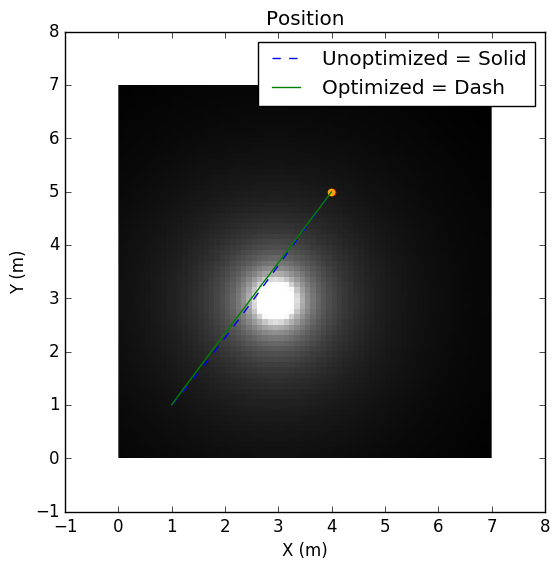

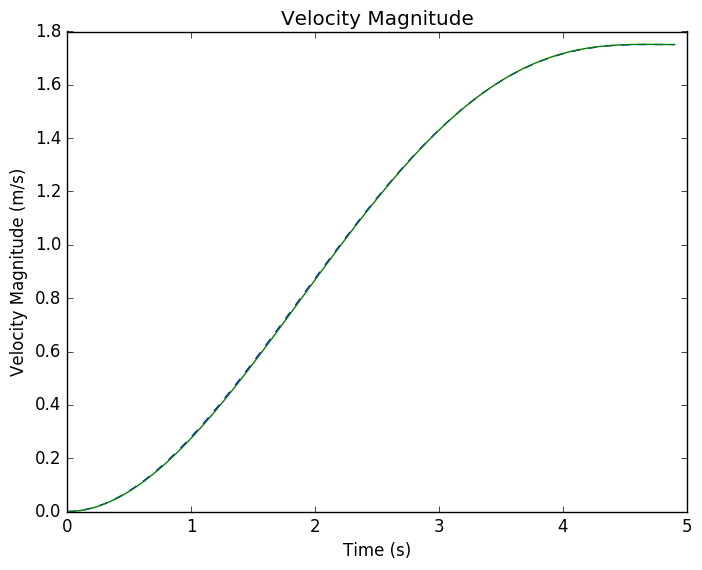

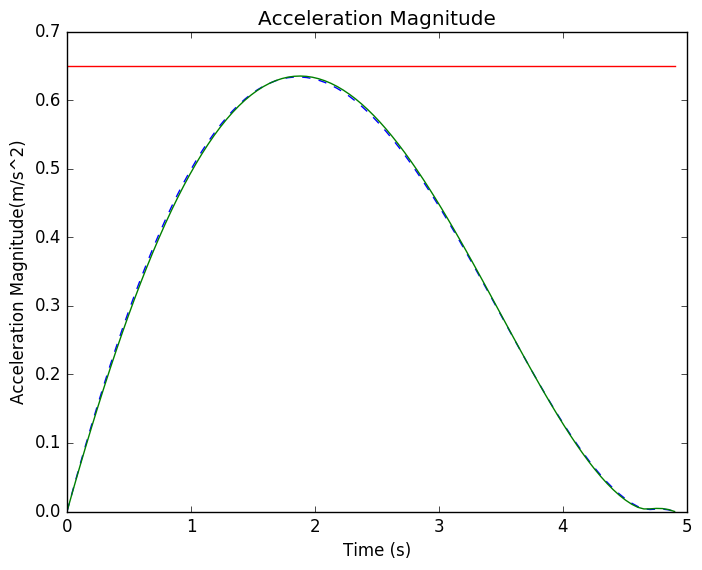

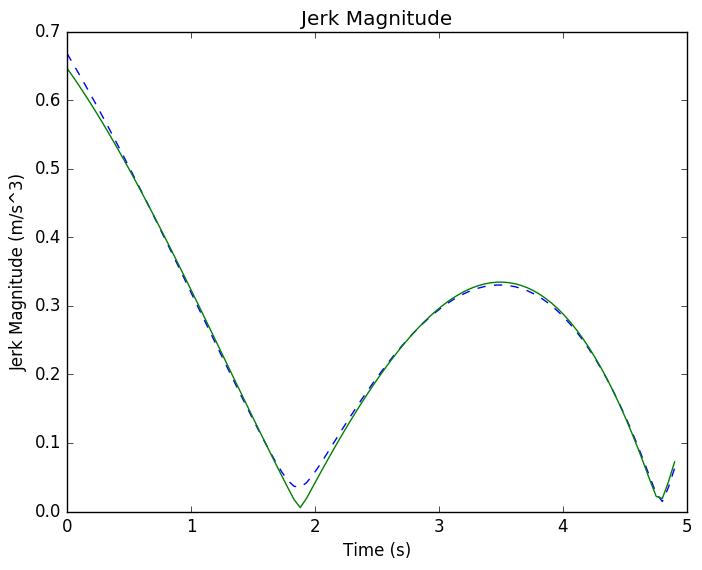

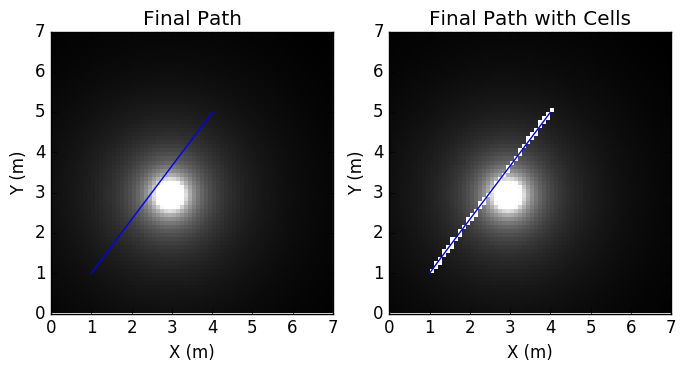

Path Planning Failed even with Restarts: Sad Face :(


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000026301748>

In [55]:
#Code For the Main Function

#Create fatal obstacle constant
FATAL_OBJECT = 255;

#set up seed for randomness
seedForRandomness =9;
println("The current seed: ", seedForRandomness)
srand(seedForRandomness);

#Initialize solver and solution
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            true,    #    PoutOfBounds::Bool                 
                            true,    #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64    
#Create a costmap
problem.costmap = createCostMap(1,problem);
problem.Pgrid_elementNum = round(Int64,ceil(problem.grid_extent/problem.grid_resolution));

#If dijkstras Create a normalized direction vector
if(problem.DijkstraNotFMT)
    addDirectedSpeed!(problem, tuningI.max_vel);
end

#Construct the constraint vectors, orders, and timeIndex given start, end, dof and soft constraint vectors
#TODO: make void functions with pointers to avoid so much copying
problem = constructConstr(problem)

#initialize time to a reasonable time so polynomial doesn't explode, a reasonable time will be
solution.totTime = initializeTime(problem, tuningI);

#while loop until verified 
while(solvHelp.PunVerified)
    #Increment time on every loop
    solution.totTime += tuningI.timeIncrease;
    
    #Form A_inv
    solvHelp.PA_inv = constr_Ainv(  problem.PconstraintOrders,
                                    problem.PtimeIndex*solution.totTime, #Multiply by the total time for proper function
                                    problem.Pdegree);

    #Add/subtract stuff to/from q_coeff if not equal to the degree
    tuningI.q_coeff = checkQcoeffs(tuningI.q_coeff, problem.Pdegree)

    #Form Q
    solvHelp.PQ = form_Q(tuningI.q_coeff,solution.totTime);

    #Form OptimizeMat
    solvHelp.PoptimizeMatrix = form_OptimizeMat(problem,tuningI,solvHelp);

    #update the free constraints as necessary
    problem.PconstrFree = updateFreeConstr(problem,solvHelp);
    #problem.PconstrFree = createRandomRestart(problem, tuningI);

    #solve for the polynomial coefficients
    solution.coeffs = solvePolysInitially(problem,solvHelp);

    #Check in bounds and collect the cells
    solution.cells, solvHelp.PoutOfBounds = occupancyCellChecker(solution, problem, tuningI);
    
    #Break if out of bounds and display an error
    if(solvHelp.PoutOfBounds)
        println("Plan Fail: Went out of Bounds")
        break;
    end

    #Verify good path
    errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)

    #If not verified increment time
    if(!isempty(errorVals))
        #Repeat loop over
        continue; 
    end
    #If verified do not say verified  until next verify
    
    #Check if not hitting an obstacle since if it is it will not succeed.
    if(any(problem.costmap[solution.cells].>=FATAL_OBJECT))
        #Break and go to random restarts
        println("Hit Object")
        #break;
    end
    
    #Plotting that can be removed later plots initial solution as a solid line
    debugPlotDash(solution, problem, tuningI)
    
    #Create a holder for the free constr
    df = form_df(problem);
    
    #Calculate the initial cost
    solution.cost = costFunc(df, solution, problem, solvHelp, tuningI)
    
    #optimize free constraints with limits built in using the COST function
    solution, problem.PconstrFree, solvHelp.PoutOfBounds = 
        selfGradientDescent(solution,problem,tuningI,solvHelp);
    
    #Plotting that can be removed later plots optimized solution as a dash line
    debugPlot(solution, problem, tuningI)
    
    #Verify good path
    errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)
    #If not verified increment time
    if(!isempty(errorVals))
        #Repeat loop over
        continue; 
    end
    solvHelp.PunVerified = false
    #If verified do not say verified  until next verify
end

#Save temporary free constraints
freeConstrFirst = problem.PconstrFree;
#Start random restarts if hitting an obstacle
restartCounter = 10;
while((any(problem.costmap[solution.cells] .>= FATAL_OBJECT) || solvHelp.PunVerified) && 
    restartCounter < tuningI.numberOfRandomRestarts)
    #Print message about hitting an obstacle and random restarting
    if(any(problem.costmap[solution.cells] .>= FATAL_OBJECT))
        println("Hit and Obstacle; Trying a random restart $(restartCounter+1)")
    end
    if(solvHelp.PunVerified)
        println("Broke limits; Trying random restart $(restartCounter+1)")
    end
    #Create random start
    problem.PconstrFree = createRandomRestart(problem, tuningI);
    #solve for the polynomial coefficients
    solution.coeffs = solvePolysInitially(problem,solvHelp);
    
    #Check in bounds and collect the cells
    solution.cells, solvHelp.PoutOfBounds = occupancyCellChecker(solution, problem, tuningI);

    #Break if out of bounds and display an error
    if(solvHelp.PoutOfBounds)
        println("Plan Fail: Went out of Bounds In the Initial Optimization")
        #break;
    end
    
    #optimize -Note there is no verification step anymore so no more increasing time
    #Create a holder for the free constr
    df = form_df(problem);
    
    #Calculate the initial cost
    solution.cost = costFunc(df, solution, problem, solvHelp, tuningI)
    #debugPlot(solution, problem, tuningI)
    #1)OPTIMIZE free constraints with limits built in; 2)COST function
    println("cost before: ", costFunc(df, solution, problem, solvHelp, tuningI))
    
    #optimize free constraints with limits built in using the COST function
    solution, problem.PconstrFree, solvHelp.PoutOfBounds = 
        selfGradientDescent(solution,problem,tuningI,solvHelp);
    df = form_df(problem);
    println("cost after: ", costFunc(df, solution, problem, solvHelp, tuningI))
    debugPlotDash(solution, problem, tuningI)
    
    #If no collision verify
    if(!(any(problem.costmap[solution.cells] .>= 255)))
        #Verify good path
        errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)
        #Check if verified, if not verified make it so that the loop happens again
        if(isempty(errorVals))
            #Repeat loop over
            solvHelp.PunVerified = false;
        else
            #Would repeat loop over if other things are tur
            solvHelp.PunVerified = true;
        end
    end
    problem.PconstrFree = freeConstrFirst;
    restartCounter += 1; 
end

#Print if made failed to plan a path around obstacle
if(restartCounter >= tuningI.numberOfRandomRestarts)
    println("Path Planning Failed even with Restarts: Sad Face :(")
end


if(!solvHelp.PoutOfBounds && !problem.isDim3)
    figure(1)
    imshow( flipCostmap(problem.costmap),
            cmap = "gray", 
            interpolation="none",
            extent=[0,problem.grid_extent,0,problem.grid_extent])
    scatter(problem.end_config[1,1],problem.end_config[2,1], color = "red")
    scatter(evaluate_poly(solution.coeffs[1,:],0,solution.totTime),evaluate_poly(solution.coeffs[2,:],0,solution.totTime), color = "orange")
    #PLOT optimized function?
else
    #Plotting that will occur if path goes out of bounds
    debugPlot(solution, problem, tuningI)
end

#####DEBUGGING With Labels Home Dog!###############
legend(["Unoptimized = Solid", "Optimized = Dash"], loc = "Best")
pathCellPlot(problem, solution, tuningI)
figure(3)
times = linspace(0,solution.totTime, tuningI.timeRes)
plot(times, ones(size(times))*tuningI.max_accel)
###########################

#Return path

The current seed: 9


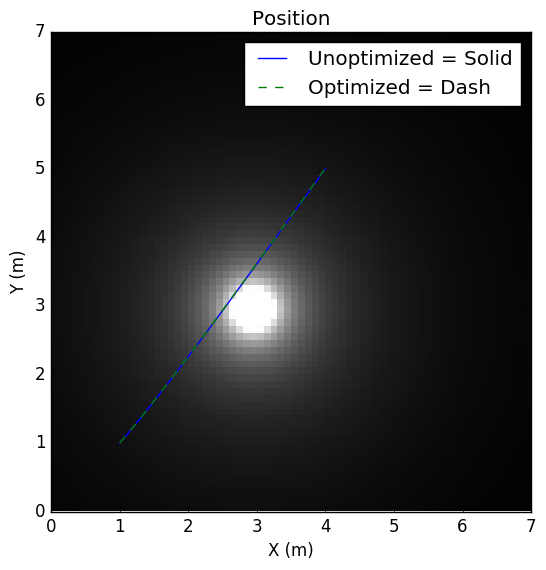

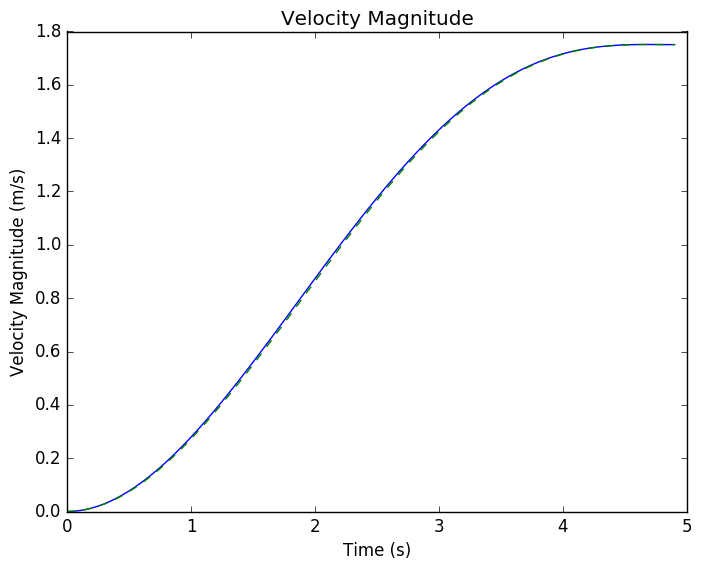

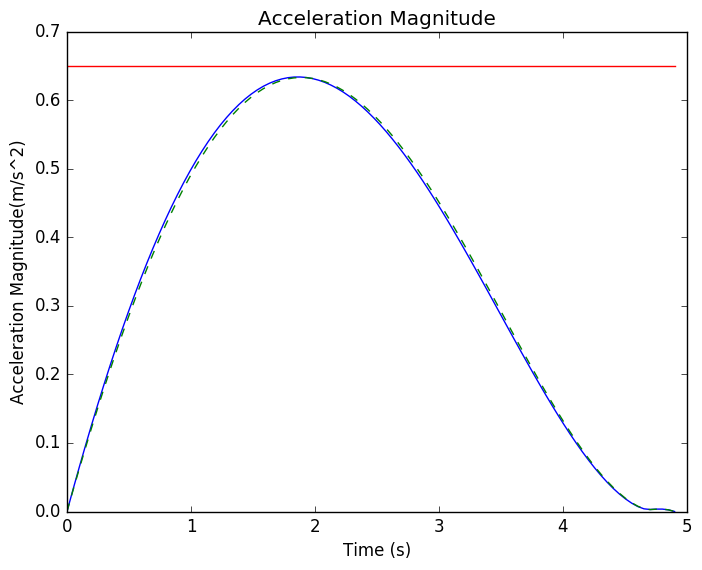

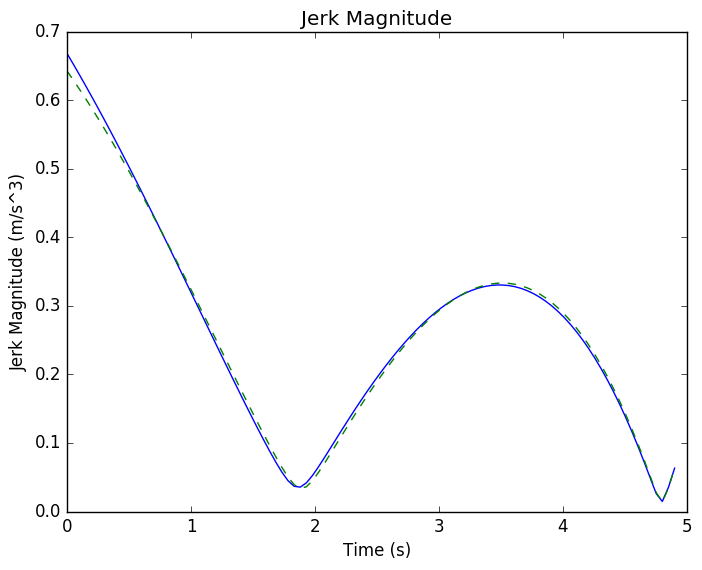

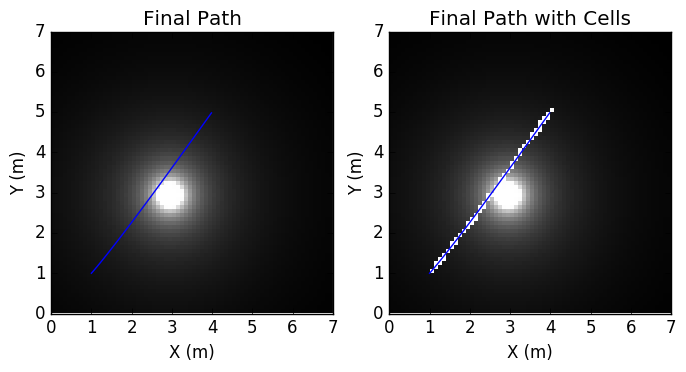

[-9.77893e-6,0.707156,-0.000564244,-0.000168874,0.707057,9.47358e-5]
[-0.000673855,0.706946,-0.00064147,-0.000200721,0.707266,-0.000235831]


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000026C69A58>

In [7]:
#Code For the Main Function

#Create fatal obstacle constant
FATAL_OBJECT = 255;

#set up seed for randomness
seedForRandomness =9;
println("The current seed: ", seedForRandomness)
srand(seedForRandomness);

#Initialize solver and solution
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            true,    #    PoutOfBounds::Bool                 
                            true,    #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64    
#Create a costmap
problem.costmap = createCostMap(1,problem);
problem.Pgrid_elementNum = round(Int64,ceil(problem.grid_extent/problem.grid_resolution));

#If dijkstras Create a normalized direction vector
if(problem.DijkstraNotFMT)
    addDirectedSpeed!(problem, tuningI.max_vel);
end

#Construct the constraint vectors, orders, and timeIndex given start, end, dof and soft constraint vectors
#TODO: make void functions with pointers to avoid so much copying
problem = constructConstr(problem)

#initialize time to a reasonable time so polynomial doesn't explode, a reasonable time will be
solution.totTime = initializeTime(problem, tuningI);

#while loop until verified 
while(solvHelp.PunVerified)
    #Increment time on every loop
    solution.totTime += tuningI.timeIncrease;
    
    #Form A_inv
    solvHelp.PA_inv = constr_Ainv(  problem.PconstraintOrders,
                                    problem.PtimeIndex*solution.totTime, #Multiply by the total time for proper function
                                    problem.Pdegree);

    #Add/subtract stuff to/from q_coeff if not equal to the degree
    tuningI.q_coeff = checkQcoeffs(tuningI.q_coeff, problem.Pdegree)

    #Form Q
    solvHelp.PQ = form_Q(tuningI.q_coeff,solution.totTime);

    #Form OptimizeMat
    solvHelp.PoptimizeMatrix = form_OptimizeMat(problem,tuningI,solvHelp);

    #update the free constraints as necessary
    problem.PconstrFree = updateFreeConstr(problem,solvHelp);
    #problem.PconstrFree = createRandomRestart(problem, tuningI);

    #solve for the polynomial coefficients
    solution.coeffs = solvePolysInitially(problem,solvHelp);

    #Check in bounds and collect the cells
    solution.cells, solvHelp.PoutOfBounds = occupancyCellChecker(solution, problem, tuningI);

    #Break if out of bounds and display an error
    if(solvHelp.PoutOfBounds)
        println("Plan Fail: Went out of Bounds")
        break;
    end

    #Verify good path
    errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)

    #If not verified increment time
    if(!isempty(errorVals))
        #Repeat loop over
        continue; 
    end
    #If verified do not say verified  until next verify
    
    #Check if not hitting an obstacle since if it is it will not succeed.
    if(any(problem.costmap[solution.cells].>=FATAL_OBJECT))
        #Break and go to random restarts
        println("Hit Object")
        #break;
    end
    
    #Plotting that can be removed later plots initial solution as a solid line
    debugPlot(solution, problem, tuningI)
    
    #Create a holder for the free constr
    df = form_df(problem);
    
    #Calculate the initial cost
    solution.cost = costFunc(df, solution, problem, solvHelp, tuningI)
    
    #optimize free constraints with limits built in using the COST function
    solution, problem.PconstrFree, solvHelp.PoutOfBounds = 
        selfGradientDescent(solution,problem,tuningI,solvHelp);
    
    #Plotting that can be removed later plots optimized solution as a dash line
    debugPlotDash(solution, problem, tuningI)
    
    #Verify good path
    errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)

    #If not verified increment time
    if(!isempty(errorVals))
        #Repeat loop over
        continue; 
    end
    solvHelp.PunVerified = false
    #If verified do not say verified  until next verify
end

#Save temporary free constraints
freeConstrFirst = problem.PconstrFree;
#Start random restarts if hitting an obstacle
restartCounter = 0;
while((any(problem.costmap[solution.cells] .>= FATAL_OBJECT) || solvHelp.PunVerified) && 
    restartCounter < tuningI.numberOfRandomRestarts)
    #Print message about hitting an obstacle and random restarting
    if(any(problem.costmap[solution.cells] .>= FATAL_OBJECT))
        println("Hit and Obstacle; Trying a random restart $(restartCounter+1)")
    end
    if(solvHelp.PunVerified)
        println("Broke limits; Trying random restart $(restartCounter+1)")
    end
    #Create random start
    problem.PconstrFree = createRandomRestart(problem, tuningI);
    #solve for the polynomial coefficients
    solution.coeffs = solvePolysInitially(problem,solvHelp);
    
    #Check in bounds and collect the cells
    solution.cells, solvHelp.PoutOfBounds = occupancyCellChecker(solution, problem, tuningI);

    #Break if out of bounds and display an error
    if(solvHelp.PoutOfBounds)
        println("Plan Fail: Went out of Bounds In the Initial Optimization")
        #break;
    end
    
    #optimize -Note there is no verification step anymore so no more increasing time
    #Create a holder for the free constr
    df = form_df(problem);
    
    #Calculate the initial cost
    solution.cost = costFunc(df, solution, problem, solvHelp, tuningI)
    debugPlot(solution, problem, tuningI)
    #1)OPTIMIZE free constraints with limits built in; 2)COST function
    println("cost before: ", costFunc(df, solution, problem, solvHelp, tuningI))
    
    #optimize free constraints with limits built in using the COST function
    solution, problem.PconstrFree, solvHelp.PoutOfBounds = 
        selfGradientDescent(solution,problem,tuningI,solvHelp);
    df = form_df(problem);
    println("cost after: ", costFunc(df, solution, problem, solvHelp, tuningI))
    debugPlotDash(solution, problem, tuningI)
    
    #If no collision verify
    if(!(any(problem.costmap[solution.cells] .>= 255)))
        #Verify good path
        errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)
        #Check if verified, if not verified make it so that the loop happens again
        if(isempty(errorVals))
            #Repeat loop over
            solvHelp.PunVerified = false;
        else
            #Would repeat loop over if other things are tur
            solvHelp.PunVerified = true;
        end
    end
    problem.PconstrFree = freeConstrFirst;
    restartCounter += 1; 
end

#Print if made failed to plan a path around obstacle
if(restartCounter >= tuningI.numberOfRandomRestarts)
    println("Path Planning Failed even with Restarts: Sad Face :(")
end


if(!solvHelp.PoutOfBounds && !problem.isDim3)
    figure(1)
    imshow( flipCostmap(problem.costmap),
            cmap = "gray", 
            interpolation="none",
            extent=[0,problem.grid_extent,0,problem.grid_extent])
    #PLOT optimized function?
else
    #Plotting that will occur if path goes out of bounds
    debugPlot(solution, problem, tuningI)
end

#####DEBUGGING With Labels Home Dog!###############
legend(["Unoptimized = Solid", "Optimized = Dash"], loc = "Best")
pathCellPlot(problem, solution, tuningI)
figure(3)
times = linspace(0,solution.totTime, tuningI.timeRes)
plot(times, ones(size(times))*tuningI.max_accel)
###########################

#Return path

In [ ]:
#A test to test a series of values for one parameter
#Initialize seedForRandomness
seedForRandomness = 1;
first = true
plotVals = [];
range = 0.0:0.1:1
#range = 10.0.^range
for i =range
    println("Currently at value: ", i)
    #Set Parameter to change
    tuningI.percentAcc = i;
    #Run Planner
    solution = runPathPlanner(tuningI, 
                    problem)
    #Plots
    if(first)
        debugPlotDash(solution, problem, tuningI)
        first = false;
    else
        debugPlot(solution, problem, tuningI)
    end
    plotVals = [plotVals; solution.cost+tuningI.timeWeight*solution.totTime]
end
figure(5)
plot(range, plotVals)
title("Cost vs Percent Acceleration")
xlabel("Percent Acceleration (units)")
ylabel("Total Cost + Time Cost (units)")
#plot obstacle
if(!solvHelp.PoutOfBounds)
    figure(1)
    legend(["1", "2", "3", "4", "5", "6", "7","8", "9", "10"], loc = "Best")
    imshow( flipCostmap(problem.costmap),
            cmap = "Reds", 
            interpolation="none",
            extent=[0,problem.grid_extent,0,problem.grid_extent])
end

In [ ]:
#Do the lotus test
lotusTest(  5.0,       # initial_distance::Float64, 
            tuningI,   # tuning::TuningParams, 
            2,         # number2Rotate::Int64,
            2.0,       # distanceChange::Float64, 
            1,         # figureNum::Int64)
            problem)   # pathProb::PathProblem

In [ ]:
#Easy Bump Test
easyAvoidBumpTest(  tuningI,# bumpTuning::TuningParams, 
                    problem,# pathProblem::PathProblem, 
                    5000,   # bumpSize::Int64)
                    2,      # figNum::Int64 = 1
                    7.0)    # bumpYLoc::Float64 default is 5.0

In [ ]:
#Doorway Test
#TODO: make params more understandable/consistent with user expectations
#TODO: Add input validation to this test
doorwayTest(tuningI,#wallTuning::TuningParams, 
            problem,#pathProblem::PathProblem, 
            30,     #wallSize::Int64, 
            3,      #figNum::Int64, 
            7.0,    #doorYLoc::Float64, 
            10.0,   #doorWidth::Float64)
            true,   #wallBehindDoor::Bool = false, 
            1.5)    #wallDistance::Float64 = 2.0

In [ ]:
#Hallway Test
#TODO: Add input validation to this test
hallwayTest(tuningI,#hallTuning::TuningParams, 
            problem,#pathProblem::PathProblem, 
            35,     #wallSize::Int64, 
            4)      #figNum::Int64)

In [ ]:
#Random Ros Bag Test
#Description - read in a ros bag's costmap and path for that costmap
#Inputs
# rosbag
#Expected Outcomes - a plot 

#Pseudo code since I do not know how to do this in Julia yet
#Read in rosbag
#Record a coinciding costmap and global path
#Translate to odom frame
#Pick local goals
#Start timer
#Run path planner
#If unsuccessful choose a different goal until out of goals or successful
#End timer
#Print time
#Plot planned path over the costmap

In [ ]:
    imshow( flipCostmap(problem.costmap),
            cmap = "reds", 
            interpolation="none",
            extent=[0,problem.grid_extent,0,problem.grid_extent])

In [ ]:
for i  = 1:size(problem.costmap,1)
    println(problem.costmap[1,:])
end

In [ ]:
println(isnum(2))